# Level-3 Backtesting

The Level-3 feed data for HftBacktest is built from DataBento's CME Market-By-Order data

In [1]:
from hftbacktest.data.utils import databento

for date in range(20240609, 20240615):
    databento.convert(f'data/db/glbx-mdp3-{date}.mbo.dbn.zst', 'BTCM4', output_filename=f'data/BTCM4_{date}_l3.npz')

Correcting the latency
Correcting the event order
Saving to data/BTCM4_20240609_l3.npz
Correcting the latency
Correcting the event order
Saving to data/BTCM4_20240610_l3.npz
Correcting the latency
Correcting the event order
Saving to data/BTCM4_20240611_l3.npz
Correcting the latency
Correcting the event order
Saving to data/BTCM4_20240612_l3.npz
Correcting the latency
Correcting the event order
Saving to data/BTCM4_20240613_l3.npz
Correcting the latency
Correcting the event order
Saving to data/BTCM4_20240614_l3.npz


In [2]:
import numpy as np

from numba import njit, uint64, float64
from numba.typed import Dict

from hftbacktest import BUY, SELL, GTC, LIMIT

@njit
def gridtrading(hbt, recorder, skew):
    asset_no = 0
    tick_size = hbt.depth(asset_no).tick_size
    grid_num = 10
    max_position = 5
    grid_interval = tick_size * 1
    half_spread = tick_size * 0.4

    # Running interval in nanoseconds.
    while hbt.elapse(100_000_000) == 0:
        # Clears cancelled, filled or expired orders.        
        hbt.clear_inactive_orders(asset_no)

        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)
        
        best_bid = depth.best_bid
        best_ask = depth.best_ask
        
        mid_price = (best_bid + best_ask) / 2.0
        
        order_qty = 1 # np.round(notional_order_qty / mid_price / hbt.depth(asset_no).lot_size) * hbt.depth(asset_no).lot_size
        
        # The personalized price that considers skewing based on inventory risk is introduced, 
        # which is described in the well-known Stokov-Avalleneda market-making paper.
        # https://math.nyu.edu/~avellane/HighFrequencyTrading.pdf
        alpha = 0
        reservation_price = mid_price + alpha - skew * tick_size * position

        # Since our price is skewed, it may cross the spread. To ensure market making and avoid crossing the spread, 
        # limit the price to the best bid and best ask.
        bid_price = np.minimum(reservation_price - half_spread, best_bid)
        ask_price = np.maximum(reservation_price + half_spread, best_ask)

        # Aligns the prices to the grid.
        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position < max_position and np.isfinite(bid_price): # position * mid_price < max_notional_position
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position > -max_position and np.isfinite(ask_price): # position * mid_price > -max_notional_position
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTC, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTC, LIMIT, False)
        
        # Records the current state for stat calculation.
        recorder.record(hbt)
    return True

In [3]:
from hftbacktest import BacktestAsset, ROIVectorMarketDepthBacktest, Recorder

asset = (
    BacktestAsset()
        .data([
            'data/BTCM4_20240609_l3.npz',
            'data/BTCM4_20240610_l3.npz',
            'data/BTCM4_20240611_l3.npz',
            'data/BTCM4_20240612_l3.npz',
            'data/BTCM4_20240613_l3.npz',
            'data/BTCM4_20240614_l3.npz',
        ])
        .linear_asset(5) 
        .constant_latency(100_000, 100_000)
        .l3_fifo_queue_model() 
        .no_partial_fill_exchange()
        .trading_qty_fee_model(5, 5)
        .tick_size(5)
        .lot_size(1)
        .roi_lb(0.0)    
        .roi_ub(100000.0)
)
hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 5_000_0000)

In [4]:
%%time
gridtrading(hbt, recorder.recorder, 0.5)

_ = hbt.close()

CPU times: user 35.6 s, sys: 336 ms, total: 35.9 s
Wall time: 32.4 s


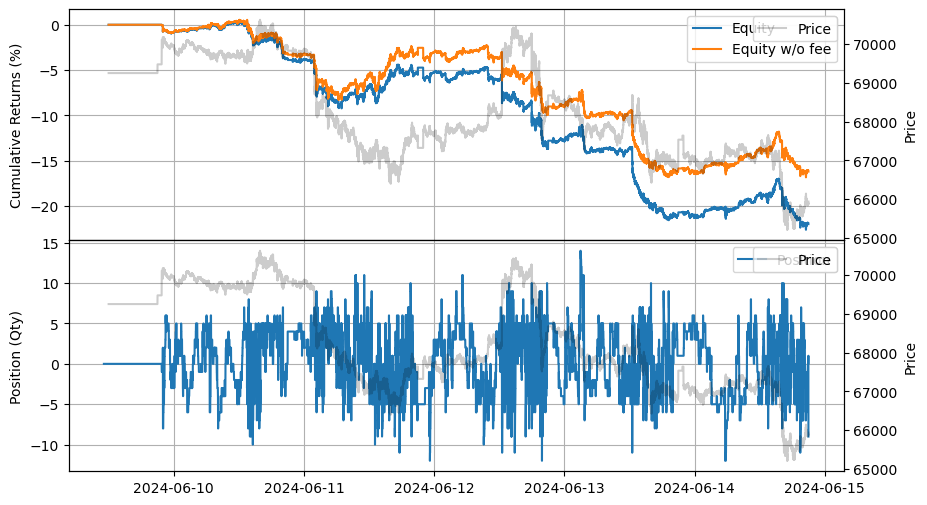

In [5]:
from hftbacktest.stats import LinearAssetRecord

stats = LinearAssetRecord(recorder.get(0)).contract_size(5).stats(book_size=1_000_000)

l3_backtest_equity = stats.entire['equity_wo_fee']

stats.plot()

The following code constructs Level-2 data from Level-3 data for the purpose of comparing backtesting results between Level-3 and Level-2. Level-2 estimates queue positions using a model, whereas Level-3 determines queue positions directly from the order data.

In [6]:
from hftbacktest.data import correct_event_order, validate_event_order
from hftbacktest import (
    EXCH_EVENT,
    LOCAL_EVENT,
    TRADE_EVENT,
    DEPTH_EVENT,
    DEPTH_CLEAR_EVENT,
    ADD_ORDER_EVENT,
    MODIFY_ORDER_EVENT,
    CANCEL_ORDER_EVENT,
    FILL_EVENT,
    BUY_EVENT,
    SELL_EVENT,
    event_dtype
)

from numba.experimental import jitclass
from numba.types import DictType, int64

@jitclass
class L3MarketDepth:
    bid_depth: DictType(int64, float64)    
    ask_depth: DictType(int64, float64)
    order_book_px: DictType(uint64, float64)
    order_book_qty: DictType(uint64, float64)
    tick_size: float64
    
    def __init__(self, tick_size):
        self.bid_depth = Dict.empty(int64, float64)
        self.ask_depth = Dict.empty(int64, float64)
        self.order_book_px = Dict.empty(uint64, float64)
        self.order_book_qty = Dict.empty(uint64, float64)
        self.tick_size = tick_size

    def add_order(self, ev):
        if ev.order_id in self.order_book_qty:
            print('add_order: OrderIdExist', ev.order_id)
            raise ValueError

        self.order_book_px[ev.order_id] = ev.px;

        l2_ev = np.empty(1, event_dtype)
        l2_ev[0] = ev
        l2_ev[0].ev = (l2_ev[0].ev & ~0xff) | DEPTH_EVENT
        
        price_tick = int(round(ev.px / self.tick_size))
        if ev.ev & BUY_EVENT == BUY_EVENT:
            self.order_book_qty[ev.order_id] = ev.qty;
            
            if price_tick not in self.bid_depth:
                self.bid_depth[price_tick] = 0.0
            self.bid_depth[price_tick] += ev.qty
            
            l2_ev[0].qty = round(self.bid_depth[price_tick])
        elif ev.ev & SELL_EVENT == SELL_EVENT:
            self.order_book_qty[ev.order_id] = -ev.qty;
            
            if price_tick not in self.ask_depth:
                self.ask_depth[price_tick] = 0.0
            self.ask_depth[price_tick] += ev.qty
            
            l2_ev[0].qty = round(self.ask_depth[price_tick])
        
        return l2_ev[0]
            
    def modify_order(self, ev):
        if ev.order_id not in self.order_book_qty:
            print('modify_order: OrderNotFound', ev.order_id)
            raise ValueError

        prev_px = self.order_book_px[ev.order_id]
        prev_qty = self.order_book_qty[ev.order_id]

        l2_ev = np.empty(2, event_dtype)
        l2_ev[1] = l2_ev[0] = ev
        l2_ev[0].ev = (l2_ev[0].ev & ~0xff) | DEPTH_EVENT
        n = 0
        
        if prev_qty > 0:
            price_tick = int(round(prev_px / self.tick_size))
            self.bid_depth[price_tick] -= prev_qty
            
            if int(round(prev_px / self.tick_size)) != int(round(ev.px / self.tick_size)):
                l2_ev[0].px = prev_px
                l2_ev[0].qty = round(self.bid_depth[price_tick])
                n = 1
        elif prev_qty < 0:
            price_tick = int(round(prev_px / self.tick_size))
            self.ask_depth[price_tick] -= np.abs(prev_qty)

            if int(round(prev_px / self.tick_size)) != int(round(ev.px / self.tick_size)):
                l2_ev[0].px = prev_px
                l2_ev[0].qty = round(self.ask_depth[price_tick])
                n = 1
        
        self.order_book_px[ev.order_id] = ev.px;

        price_tick = int(round(ev.px / self.tick_size))
        if ev.ev & BUY_EVENT == BUY_EVENT:
            self.order_book_qty[ev.order_id] = ev.qty;
            
            if price_tick not in self.bid_depth:
                self.bid_depth[price_tick] = 0.0
            self.bid_depth[price_tick] += ev.qty
            
            l2_ev[n].qty = round(self.bid_depth[price_tick])
        elif ev.ev & SELL_EVENT == SELL_EVENT:
            self.order_book_qty[ev.order_id] = -ev.qty;
            
            if price_tick not in self.ask_depth:
                self.ask_depth[price_tick] = 0.0
            self.ask_depth[price_tick] += ev.qty
            
            l2_ev[n].qty = round(self.ask_depth[price_tick])
            
        return l2_ev[:n + 1]

    def cancel_order(self, ev):
        if ev.order_id not in self.order_book_qty:
            print('cancel_order: OrderNotFound', ev.order_id, ev)
            raise ValueError
            
        del self.order_book_px[ev.order_id]
        del self.order_book_qty[ev.order_id]

        l2_ev = np.empty(1, event_dtype)
        l2_ev[0] = ev
        l2_ev[0].ev = (l2_ev[0].ev & ~0xff) | DEPTH_EVENT
        
        if ev.ev & BUY_EVENT == BUY_EVENT:
            price_tick = int(round(ev.px / self.tick_size))
            self.bid_depth[price_tick] -= ev.qty
            l2_ev[0].qty = round(self.bid_depth[price_tick])
        elif ev.ev & SELL_EVENT == SELL_EVENT:
            price_tick = int(round(ev.px / self.tick_size))
            self.ask_depth[price_tick] -= ev.qty
            l2_ev[0].qty = round(self.ask_depth[price_tick])

        return l2_ev[0]

    def clear(self):
        self.order_book_px.clear()
        self.order_book_qty.clear()
        self.bid_depth.clear()
        self.ask_depth.clear()

@njit
def convert_l3_to_l2(data, tick_size):
    result = np.empty(len(data) * 4, event_dtype)
    local_md = L3MarketDepth(tick_size)
    exch_md = L3MarketDepth(tick_size)
    rn = 0
    for i in range(len(data)):
        if data[i].ev & (EXCH_EVENT | LOCAL_EVENT) == EXCH_EVENT | LOCAL_EVENT:
            if data[i].ev & 0xff == ADD_ORDER_EVENT:
                result[rn] = exch_md.add_order(data[i])
                rn += 1
            elif data[i].ev & 0xff == MODIFY_ORDER_EVENT:
                l2_ev = exch_md.modify_order(data[i])
                result[rn] = l2_ev[0]
                rn += 1
                if len(l2_ev) == 2:
                    result[rn] = l2_ev[1]
                    rn += 1
            elif data[i].ev & 0xff == CANCEL_ORDER_EVENT:
                result[rn] = exch_md.cancel_order(data[i])
                rn += 1
            elif data[i].ev & 0xff == FILL_EVENT:
                continue
            elif data[i].ev & 0xff == DEPTH_CLEAR_EVENT:
                exch_md.clear()
                result[rn] = data[i]
                rn += 1
            else:
                result[rn] = data[i]
                rn += 1
        else:
            # DataBento's CME data is aligned in both local and exchange timestamps.
            raise ValueError
    return result[:rn]

In [7]:
for date in range(20240609, 20240615):
    l3 = databento.convert(f'data/db/glbx-mdp3-{date}.mbo.dbn.zst', 'BTCM4')
    tick_size = 5
    l2 = convert_l3_to_l2(l3, tick_size)
    
    data = correct_event_order(
        l2,
        np.argsort(l2['exch_ts'], kind='mergesort'),
        np.argsort(l2['local_ts'], kind='mergesort')
    )

    validate_event_order(data)
    
    np.savez_compressed(f'data/BTCM4_{date}_l2.npz', data=data)

Correcting the latency
Correcting the event order
Correcting the latency
Correcting the event order
Correcting the latency
Correcting the event order
Correcting the latency
Correcting the event order
Correcting the latency
Correcting the event order
Correcting the latency
Correcting the event order


In [8]:
from hftbacktest import BacktestAsset, ROIVectorMarketDepthBacktest, Recorder

asset = (
    BacktestAsset()
        .data([
            'data/BTCM4_20240609_l2.npz',
            'data/BTCM4_20240610_l2.npz',
            'data/BTCM4_20240611_l2.npz',
            'data/BTCM4_20240612_l2.npz',
            'data/BTCM4_20240613_l2.npz',
            'data/BTCM4_20240614_l2.npz',
        ])
        .linear_asset(5) 
        .constant_latency(100_000, 100_000)
        .power_prob_queue_model3(3.0)
        .no_partial_fill_exchange()
        .trading_qty_fee_model(5, 5)
        .tick_size(5)
        .lot_size(1)
        .roi_lb(0.0)    
        .roi_ub(100000.0)
)
hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 5_000_0000)

In [9]:
%%time
gridtrading(hbt, recorder.recorder, 0.5)

_ = hbt.close()

CPU times: user 28.9 s, sys: 401 ms, total: 29.3 s
Wall time: 24.9 s


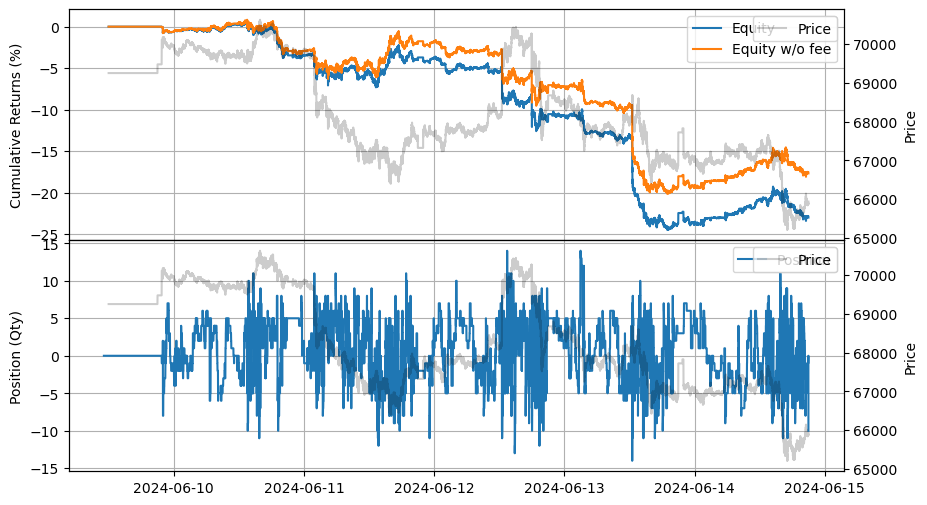

In [10]:
stats = LinearAssetRecord(recorder.get(0)).contract_size(5).stats(book_size=1_000_000)

l2_backtest_equity = stats.entire['equity_wo_fee']

stats.plot()

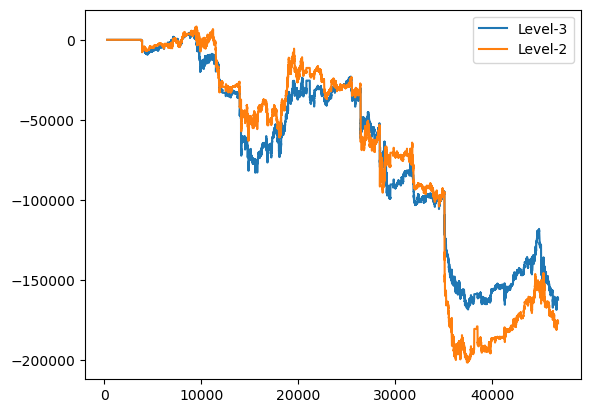

In [11]:
from matplotlib import pyplot as plt

plt.plot(l3_backtest_equity)
plt.plot(l2_backtest_equity)
plt.legend(['Level-3', 'Level-2'])

The impact of the difference can vary depending on the characteristics of the strategy; for some strategies, Level-2 estimation may be sufficiently accurate, while for others, it may not be. This comparison is intended to highlight these differences. In markets that only provide Level-2 data, it is important to develop a realistic queue position model based on live trading data. Although Level-3 data offers direct order queue position information, it is still crucial to validate backtesting results against live trading results. For example, in this CME Level-3 backtest, the market depth doesn't include implied orders.